In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Value class

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    # ---------- Binary operators ----------

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, (Value,)) else Value(other, label='num')
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __sub__(self, other):
        return self + (-other)

    # ---------- Reversed binary ops ----------

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return self - other

    # ---------- Unary ops ----------

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Only supporting `int` or `float` powers for now.'

        out = Value(self.data**other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += (other * out.data/self.data) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def tanh(self):
        n = self.data
        e_pow_x = math.exp(2*n)
        t = (e_pow_x - 1)/(e_pow_x + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        out = Value(math.exp(self.data), _children=(self,), _op='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # ----------- Auto-grad stuff ----------
    def _get_topo(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        return topo

    def backward(self):
        topo = self._get_topo()
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### function for displaying operations as graph

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = f" {n.label} | data={n.data:.4f} | grad={n.grad:.4f} ", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# backward pass on neuron

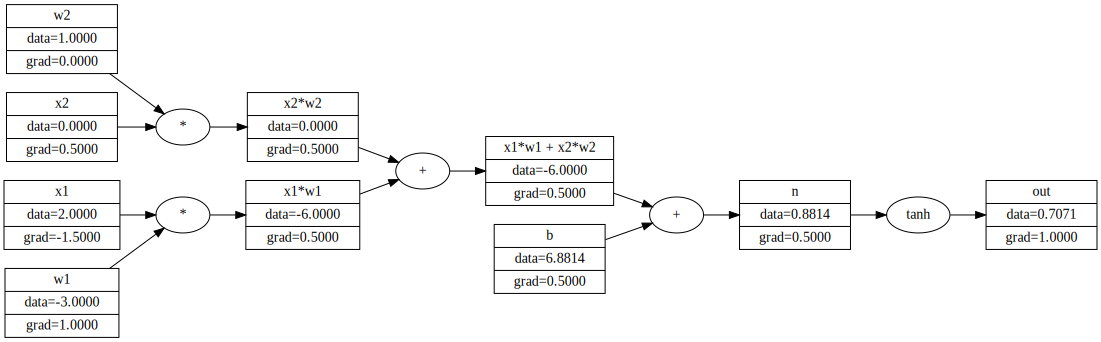

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'out'
o.backward()
draw_dot(o)

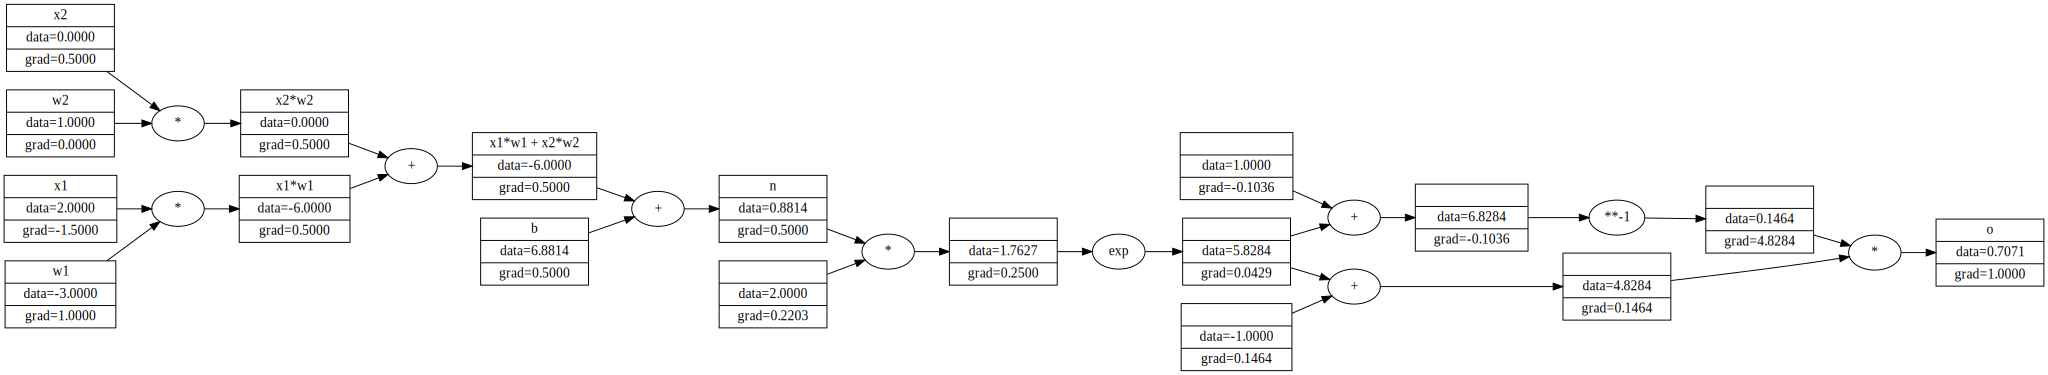

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# o = n.tanh();

# --- tanh with basic operations
e = (Value(2)*n).exp()
o = (e - 1) / (e + 1); o.label='o'

o.backward()
draw_dot(o)

# The same operations using Pytorch

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

for p in [x1, x2, w1, w2]:
    p.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('forward', o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

forward 0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building MLP using micrograd

In [10]:
import random

In [11]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # Second argument is the starting value for the sum.
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs) > 1 else outs[0]

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(in_, out) for in_, out in zip(sizes, sizes[1:])]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])
model(x)
# draw_dot(model(x))  # diagram got pretty big

Value(data=-0.24390989948094804)

In [13]:
params = model.parameters()
len(params)  # l1: (3+1)*14 = 16; l2 (4+1)*4=20; l3(4+1)*1=5; l1 + l2 + l3 = 41

41

In [14]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypreds = [model(x) for x in xs]
ys, ypreds

([1.0, -1.0, -1.0, 1.0],
 [Value(data=-0.24390989948094804),
  Value(data=-0.25227135543483403),
  Value(data=-0.07799940813703567),
  Value(data=-0.29286775055852593)])

In [15]:
lr = 0.1
ep = 0

In [16]:
params = model.parameters()
for _ in range(10):
    ep += 1

    # forward pass
    ypreds = [model(x) for x in xs]
    loss = sum([(ytrue - ypred)**2 for ytrue, ypred in zip(ys, ypreds)])

    # backward pass
    for p in params:
        p.grad = 0.0  # reset (zero) the gradients
    loss.backward()

    # weights update
    for p in model.parameters():
        p.data += -lr * p.grad

    print(f'{ep:>2}. {loss.data=}')


 1. loss.data=4.628002075759882
 2. loss.data=2.0401386642411135
 3. loss.data=0.9624041740448901
 4. loss.data=0.2989735946469864
 5. loss.data=0.09691513322688274
 6. loss.data=0.0760419414604649
 7. loss.data=0.06377835990525044
 8. loss.data=0.055155111582166544
 9. loss.data=0.048610331985986556
10. loss.data=0.043430674600993355


In [18]:
ypreds

[Value(data=0.9228528122853261),
 Value(data=-0.9177452084873629),
 Value(data=-0.8676966381310016),
 Value(data=0.8850697788217403)]